# Load model

In [33]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad

# Path to Neural Fingerprint scripts
import sys
sys.path
sys.path.append('../../../scripts/baselines/neuralfingerprints/utils')
sys.path.append('../../../scripts/baselines/neuralfingerprints')

from build_vanilla_net import build_morgan_deep_net, build_standard_net
from build_convnet import build_conv_deep_net, build_convnet_fingerprint_fun
from util import normalize_array, build_batched_grad
from optimizers import adam
from util import rmse
from sklearn.metrics import r2_score

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
import matplotlib.pyplot as plt


from pathlib2 import Path
import time
import os
import json
import pickle
from argparse import ArgumentParser

from training_funcs import load_data
from mol_graph import degrees
from data_util import remove_duplicates

In [34]:
NUM_EXP = 200

In [35]:
FIGURE_PATH = '../../../data/raw/baselines/neuralfingerprint'

In [36]:
# path to datasets
DATASET_PATH = "../../../data/3_final_data/split_data"

# path to logs directory
EXPERIMENTS_DATA = "../../../data/raw/baselines/neuralfingerprint"

# logs path
LOG_PATH=os.path.join(EXPERIMENTS_DATA, "logs")

MODEL_PATH=os.path.join(EXPERIMENTS_DATA, "models")

In [37]:
path = os.path.join(LOG_PATH,'exp_'+str(NUM_EXP))
LOG_PATH = path

path = os.path.join(MODEL_PATH,'exp_'+str(NUM_EXP))
MODEL_PATH = path

In [38]:
class Args(object):
    def __init__(self, adict):
        self.__dict__.update(adict)

In [39]:
with open(os.path.join(LOG_PATH,str(NUM_EXP)+'_parameters.json'),'r') as f:
    args = Args(json.load(f))

In [40]:
# set data parameters
task_params = {'target_name' : 'logP',
           'data_file'   : args.data_file}

# load data
data = load_data(dataset_path=DATASET_PATH, prefix_name = task_params['data_file'], VALUE_COLUMN = task_params['target_name'])

train_inputs, train_targets = data['train']
val_inputs,   val_targets   = data['validation']
test_inputs,  test_targets  = data['test']

# set parameters of training    
params = {'fp_length': args.fp_length,
        'fp_depth': args.fp_depth,
        'init_scale': np.exp(args.init_scale),
        'learn_rate': np.exp(args.learn_rate),
        'l2_penalty': np.exp(args.l2_penalty),
        'l1_penalty': 0,
          'h1_size':args.h1_size,
        'conv_width':args.conv_width,
         'batch_size':100}
params['num_iters'] = args.num_epochs*len(train_inputs)/params['batch_size']

In [41]:
vanilla_net_params = dict(
    layer_sizes = [params['fp_length'], params['h1_size']],  # One hidden layer.
    normalize=True, L2_reg = params['l2_penalty'], L1_reg = params['l1_penalty'], nll_func = rmse)

In [42]:
conv_layer_sizes = [params['conv_width']] * params['fp_depth']
conv_arch_params = {'num_hidden_features' : conv_layer_sizes,
                    'fp_length' : params['fp_length'], 'normalize' : 1}
loss_fun, pred_fun, conv_parser = \
    build_conv_deep_net(conv_arch_params, vanilla_net_params, params['l2_penalty'])
num_weights = len(conv_parser)

In [43]:
best_model_name = filter(lambda x: x.startswith('model_best'), os.listdir(MODEL_PATH))

In [44]:
with open(os.path.join(MODEL_PATH, best_model_name[0])) as f:
    best_weights = pickle.load(f)

In [45]:
def parse_training_params(params):
    nn_train_params = {'num_epochs'  : args.num_epochs,
                       'batch_size'  : 100,
                       'param_scale' : params['init_scale']}

    vanilla_net_params = dict(
        layer_sizes = [params['fp_length'], params['h1_size']],  # One hidden layer.
        normalize=True, L2_reg = params['l2_penalty'], L1_reg = params['l1_penalty'], nll_func = rmse)
    return nn_train_params, vanilla_net_params

In [47]:
conv_arch_params

{'fp_length': 32, 'normalize': 1, 'num_hidden_features': [10, 10, 10]}

In [96]:
def draw_molecule_with_highlights(filename, smiles, highlight_atoms):
    drawoptions = DrawingOptions()
    drawoptions.selectColor = highlight_color
    drawoptions.elemDict = {}   # Don't color nodes based on their element.
    drawoptions.bgColor=None

    mol = Chem.MolFromSmiles(smiles)
    fig = Draw.MolToMPL(mol, highlightAtoms=highlight_atoms, size=figsize, options=drawoptions,fitImage=False)

    fig.gca().set_axis_off()
    fig.savefig(filename, bbox_inches='tight')
    plt.close(fig)


def construct_atom_neighbor_list(array_rep):
    atom_neighbour_list = []
    for degree in degrees:
        atom_neighbour_list += [list(neighbours) for neighbours in array_rep[('atom_neighbors', degree)]]
    return atom_neighbour_list


def plot(trained_weights, FIGURE_PATH = FIGURE_PATH):
    
    print "Loading data..."
    data = load_data(dataset_path=DATASET_PATH, prefix_name = task_params['data_file'], VALUE_COLUMN = task_params['target_name'])


    train_smiles, train_targets = data['train']
    val_inputs,   val_targets   = data['validation']
    test_inputs,  test_targets  = data['test']

    print "Convnet fingerprints with neural net"
    conv_arch_params['return_atom_activations'] = True
    output_layer_fun, parser, compute_atom_activations = \
       build_convnet_fingerprint_fun(**conv_arch_params)
    atom_activations, array_rep = compute_atom_activations(trained_weights, train_smiles)

    if not os.path.exists(os.path.join(FIGURE_PATH, 'figures','exp_'+str(NUM_EXP))): \
        os.makedirs(os.path.join(FIGURE_PATH, 'figures','exp_'+str(NUM_EXP)))

    parent_molecule_dict = {}
    for mol_ix, atom_ixs in enumerate(array_rep['atom_list']):
        for atom_ix in atom_ixs:
            parent_molecule_dict[atom_ix] = mol_ix

    atom_neighbor_list = construct_atom_neighbor_list(array_rep)

    def get_neighborhood_ixs(array_rep, cur_atom_ix, radius):
        # Recursive function to get indices of all atoms in a certain radius.
        if radius == 0:
            return set([cur_atom_ix])
        else:
            cur_set = set([cur_atom_ix])
            for n_ix in atom_neighbor_list[cur_atom_ix]:
                cur_set.update(get_neighborhood_ixs(array_rep, n_ix, radius-1))
            return cur_set

    # Recreate trained network.
    nn_train_params, vanilla_net_params = parse_training_params(params)
    conv_arch_params['return_atom_activations'] = False
    _, _, combined_parser = \
        build_conv_deep_net(conv_arch_params, vanilla_net_params, params['l2_penalty'])

    net_loss_fun, net_pred_fun, net_parser = build_standard_net(**vanilla_net_params)
    net_weights = combined_parser.get(trained_weights, 'net weights')
    last_layer_weights = net_parser.get(net_weights, ('weights', 0))

    active_molecules = {}
    
    for fp_ix in range(params['fp_length']):
        active_molecules[fp_ix] = []
        print "FP {0} has linear regression coefficient {1}".format(fp_ix, last_layer_weights[fp_ix][0])
        combined_list = []
        for radius in all_radii:
            fp_activations = atom_activations[radius][:, fp_ix]
            combined_list += [(fp_activation, atom_ix, radius) for atom_ix, fp_activation in enumerate(fp_activations)]

        unique_list = remove_duplicates(combined_list, key_lambda=lambda x: x[0])
        combined_list = sorted(unique_list, key=lambda x: -x[0])

        for fig_ix in range(num_figs_per_fp):
            # Find the most-activating atoms for this fingerprint index, across all molecules and depths.
            activation, most_active_atom_ix, cur_radius = combined_list[fig_ix]
            most_activating_mol_ix = parent_molecule_dict[most_active_atom_ix]
            highlight_list_our_ixs = get_neighborhood_ixs(array_rep, most_active_atom_ix, cur_radius)
            highlight_list_rdkit = [array_rep['rdkit_ix'][our_ix] for our_ix in highlight_list_our_ixs]
            active_molecules[fp_ix].append(train_smiles[most_activating_mol_ix])
            print "radius:", cur_radius, "atom list:", highlight_list_rdkit, "activation", activation
            
            draw_molecule_with_highlights(\
                os.path.join(FIGURE_PATH, 'figures','exp_'+str(NUM_EXP),"fp_{0}_highlight_{1}.png".format(fp_ix, fig_ix)),
                train_smiles[most_activating_mol_ix],
                highlight_atoms=highlight_list_rdkit)
    return active_molecules

In [97]:
all_radii = range(params['fp_depth'] + 1)
num_figs_per_fp = 11
figsize = (100, 100)
highlight_color = (30.0/255.0, 100.0/255.0, 255.0/255.0)  # A nice light blue.

In [98]:
active_molecules = plot(best_weights)

Loading data...
Convnet fingerprints with neural net
FP 0 has linear regression coefficient 0.453562208734
radius: 1 atom list: [29, 27, 28, 38] activation 0.9999522859506074
radius: 1 atom list: [29, 26, 28, 32] activation 0.9998835148950064
radius: 1 atom list: [5, 25, 26, 28] activation 0.9998727929470793
radius: 1 atom list: [18, 19, 5, 17] activation 0.9998588159494763
radius: 1 atom list: [13, 12, 28, 14] activation 0.9998534233729092
radius: 1 atom list: [3, 5, 2, 1] activation 0.9998151420369541
radius: 1 atom list: [5, 2, 3, 1] activation 0.9997868213298231
radius: 1 atom list: [29, 23, 20, 24] activation 0.9997854524738728
radius: 1 atom list: [25, 26, 29, 24] activation 0.9997255624776673
radius: 1 atom list: [1, 3, 4, 22] activation 0.999534820511479
radius: 1 atom list: [34, 12, 11, 13] activation 0.9995164872765586
FP 1 has linear regression coefficient -0.981680251059
radius: 0 atom list: [7] activation 0.9868468141781662
radius: 1 atom list: [8, 9, 7] activation 0.98370

radius: 3 atom list: [11, 12, 4, 6, 9, 10, 13, 19, 7, 8, 18] activation 0.22049020022171295
radius: 3 atom list: [13, 3, 4, 7, 12, 0, 2, 5, 6, 8, 9, 11] activation 0.21467703695984663
radius: 3 atom list: [7, 8, 10, 12, 13, 15, 16, 17, 18, 9, 11] activation 0.2131560151058939
radius: 3 atom list: [0, 2, 5, 1, 3, 6, 4, 9] activation 0.2125848586902771
FP 10 has linear regression coefficient -1.31196266658
radius: 0 atom list: [1] activation 0.4823450874801345
radius: 2 atom list: [9, 10, 7, 8, 3, 5, 6, 4] activation 0.3852038857973974
radius: 2 atom list: [19, 20, 23, 18, 21, 25, 22] activation 0.2919900084836131
radius: 2 atom list: [20, 24, 21, 23, 25, 17, 22] activation 0.2861136679499768
radius: 2 atom list: [7, 8, 6, 5, 4, 3, 10] activation 0.2758093018102202
radius: 2 atom list: [9, 10, 2, 3, 8, 4, 7] activation 0.2642907346700319
radius: 2 atom list: [8, 0, 1, 3, 15, 2, 4] activation 0.2627484186392583
radius: 2 atom list: [18, 22, 1, 3, 2, 4, 0] activation 0.2609696387476127
rad

radius: 3 atom list: [12, 9, 15, 5, 7, 8, 10, 6, 14, 4, 13] activation 0.3720930978764015
radius: 3 atom list: [0, 2, 5, 1, 3, 6, 4, 9] activation 0.36656936711978894
radius: 3 atom list: [15, 17, 1, 6, 8, 14, 16, 4, 5, 7, 9, 10, 13] activation 0.36224131087247274
radius: 3 atom list: [2, 6, 10, 0, 1, 3, 5, 8, 4, 13, 14] activation 0.36145436421117333
radius: 3 atom list: [7, 2, 3, 4, 5, 6, 8, 10, 11] activation 0.36141729695181496
FP 19 has linear regression coefficient -0.213768626257
radius: 3 atom list: [1, 3, 0, 2, 4, 6, 7, 5] activation 0.9999994433752363
radius: 3 atom list: [9, 10, 1, 3, 5, 0, 2, 4, 6, 7] activation 0.9999718183451791
radius: 3 atom list: [10, 3, 4, 6, 7, 9, 0, 12, 13, 1, 2, 8] activation 0.9999186549161708
radius: 3 atom list: [22, 5, 4, 0, 2, 1, 3, 6, 23, 24] activation 0.9997210025860773
radius: 3 atom list: [10, 11, 17, 20, 21, 4, 6, 7, 9, 18, 8, 19, 5] activation 0.9995435945501407
radius: 3 atom list: [6, 10, 0, 2, 12, 13, 1, 3, 5, 11, 4] activation 0.999

FP 28 has linear regression coefficient -2.40229140924
radius: 0 atom list: [12] activation 0.9778667414519614
radius: 0 atom list: [14] activation 0.9756980825047179
radius: 1 atom list: [0, 1] activation 0.9370980023052982
radius: 1 atom list: [0, 1] activation 0.9142912015507825
radius: 0 atom list: [6] activation 0.9035338971563823
radius: 1 atom list: [3, 4] activation 0.8893655572558186
radius: 1 atom list: [0, 1] activation 0.8852593137892769
radius: 1 atom list: [5, 4] activation 0.868058288836077
radius: 1 atom list: [19, 17] activation 0.8630546031990239
radius: 1 atom list: [8, 7] activation 0.8470402135406512
radius: 2 atom list: [34, 33, 35, 29, 31, 32] activation 0.8383877106121066
FP 29 has linear regression coefficient 1.44017089027
radius: 1 atom list: [9, 10, 11, 12] activation 0.9999862628394984
radius: 1 atom list: [12, 9, 11, 10] activation 0.9999581463926546
radius: 1 atom list: [12, 11, 10, 13] activation 0.9999126826726243
radius: 1 atom list: [5, 6, 4, 7] activ

# Get predictions for active molecules

In [99]:
active_molecules

{0: ['COCCOCCOC(=O)C(Cc1ccc(OC(=O)N(C)C)cc1)NC(=O)C1N(S(=O)(=O)c2cnn(C)c2)CSC1(C)C',
  'CCCCCCCCOC(=O)n1cnc(CC(NC(=O)c2ccc(O)[nH]2)C(O)N2CCCC2C(N)=O)c1',
  'CCCC1CC(C(=O)NC(C(C)O)C2OC(SCC)C(O)C(O)C2O)N(CC)C1',
  'CCC1C2CC3C4N(C)c5ccccc5C4(CCN3C1O)C2O',
  'COc1cc2c(cc1OC)C13CCN4CC5CCOC6CC(=O)N2C1C6C5CC43',
  'CCN(CC)S(=O)(=O)c1ccc(/C=C/C(=O)NC2CCCCC2)cc1',
  'CCN(CC)CCSC(=NO)c1noc(-c2ccccc2)n1',
  'O=C(CN1C(=O)c2ccccc2S1(=O)=O)Nc1ccc(S(=O)(=O)N2CCCCCC2)cc1',
  'COc1cccc2c(O)c3c(O)c4c(c(O)c3c(O)c12)=C(OC1CC(N(CC#N)CC(=O)O)C(O)C(C)O1)CC(O)(C(C)=O)C=4',
  'CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C',
  'c1cnc2c(c1)[nH]c(=NCCCN1CCN(CCCN=c3[nH]c4cccnc4n4cccc34)CC1)c1cccn12'],
 1: ['CCN(CC)CCSC(=NO)c1noc(-c2ccccc2)n1',
  'O=[N+]([O-])c1cccc(SSc2cccc([N+](=O)[O-])c2)c1',
  'N#Cc1c(N)sc2ccccc12',
  'CCOP(=S)(CC)Oc1cc(Cl)c(Cl)cc1Cl',
  'S=C(SSSSC(=S)N1CCCCC1)N1CCCCC1',
  'CCS(=O)c1sc(Cl)cc1C#N',
  'CN(C)C(CSS(=O)(=O)c1ccccc1)CSS(=O)(=O)c1ccccc1',
  'Cc1c(C#N)sc(S(C)=O)c1-c1ccc(Cl)cc1',
  'CCOP(=

In [100]:
import pandas as pd
from sklearn.metrics import mean_squared_error

In [101]:
SMILES_COLUMN = 'smiles'
VALUE_COLUMN = 'logP'
PRED_COLUMN = 'logP_pred'

In [102]:
DATA_PREDS_PATH = '../../../data/4_best_baselines_predictions/neuralfingerprint'

In [71]:
train_predictions = pd.read_csv(os.path.join(DATA_PREDS_PATH,'logp_wo_averaging_train_preds.csv'))
val_predictions = pd.read_csv(os.path.join(DATA_PREDS_PATH,'logp_wo_averaging_validation_preds.csv'))
test_predictions = pd.read_csv(os.path.join(DATA_PREDS_PATH,'logp_wo_averaging_test_preds.csv'))

In [68]:
predictions = pd.concat([train_predictions, val_predictions, test_predictions])

In [77]:
predictions.head()

,smiles,logP,logP_pred
0,NCCCCC(NC(CCc1ccccc1)C(=O)O)C(=O)N1CCCC1C(=O)O,-1.01,-0.599925
1,CCN(CC)CCSC(=NO)c1noc(-c2ccccc2)n1,2.13,3.252617
2,C=CCc1cccc2c(=O)c(C)c(-c3ccccc3)oc12,4.67,4.890304
3,COC(=O)NC1=NC(c2ccccc2Br)CN1,1.85,2.262368
4,CC(=O)C=Cc1ccco1,1.35,0.984675


In [103]:
active_molecules_preds = {}
active_molecules_preds_RMSE = {}
for fp in active_molecules.keys():
    list_of_smiles = active_molecules[fp]
    smiles_preds = predictions[predictions[SMILES_COLUMN].isin(list_of_smiles)]
    active_molecules_preds[fp] = smiles_preds
    active_molecules_preds_RMSE[fp] = mean_squared_error(smiles_preds[VALUE_COLUMN],smiles_preds[PRED_COLUMN])**0.5
    print(smiles_preds)

                                                 smiles  logP  logP_pred
1                    CCN(CC)CCSC(=NO)c1noc(-c2ccccc2)n1  2.13   3.252617
38    c1cnc2c(c1)[nH]c(=NCCCN1CCN(CCCN=c3[nH]c4cccnc...  5.05   4.284886
84     COc1cc2c(cc1OC)C13CCN4CC5CCOC6CC(=O)N2C1C6C5CC43  0.84   1.417909
85    CCCC1CC(C(=O)NC(C(C)O)C2OC(SCC)C(O)C(O)C2O)N(C...  1.91   0.522730
434   COCCOCCOC(=O)C(Cc1ccc(OC(=O)N(C)C)cc1)NC(=O)C1...  1.41   2.312944
469   COc1cccc2c(O)c3c(O)c4c(c(O)c3c(O)c12)=C(OC1CC(...  0.03   1.267873
568       CCN(CC)S(=O)(=O)c1ccc(/C=C/C(=O)NC2CCCCC2)cc1  4.34   4.153650
1011  CCCCCCCCOC(=O)n1cnc(CC(NC(=O)c2ccc(O)[nH]2)C(O...  1.82   1.552834
1116  O=C(CN1C(=O)c2ccccc2S1(=O)=O)Nc1ccc(S(=O)(=O)N...  4.73   3.830757
4592              CCC1C2CC3C4N(C)c5ccccc5C4(CCN3C1O)C2O  1.81   1.971308
5300         CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C  2.58   3.318700
                                                smiles  logP  logP_pred
1                   CCN(CC)CCSC(=NO)c1noc(-c2ccccc2)

                                      smiles  logP  logP_pred
18             O=S(=O)(Nc1cccc(F)c1)C(F)(F)F  3.42   2.836226
42        CC(=O)C(C#N)=NNc1ccc(SC(F)(F)F)cc1  5.04   4.111878
368            CCCCOn1c(=O)[nH]c(C)c(Br)c1=O  1.24   0.993362
1103             CCC(=O)n1c(=O)[nH]cc(F)c1=O  0.19  -0.642222
1654                  FS(F)(F)(F)(F)c1ccccc1  3.36   3.588575
2395                CCCOn1c(=O)cc(C)[nH]c1=O  0.30  -0.421255
4672     CN(CCCn1ccnc1C=NO)S(=O)(=O)C(F)(F)F  1.77   1.812614
4857               O=S(=O)(c1ccccc1)C(F)(F)F  2.69   2.113040
5949              CCOCCOCCOP(=S)(N1CC1)N1CC1  0.38   0.705792
6486  CC(=O)N(c1ccc(N2CCOCC2)nn1)n1c(C)ccc1C  1.64   1.001242
7482                   O=C(C(F)(F)F)C(F)(F)F  1.46   1.626075
                                                 smiles  logP  logP_pred
28    CC(C)CC(N)C(=O)NC(CC(C)C)C(=O)NC(CC(C)C)C(=O)N... -0.51  -0.398213
299                CC(CC(=O)O)CC(=O)c1ccc(-c2ccccc2)cc1  3.82   3.952169
431                                  

In [109]:
from collections import OrderedDict
from operator import itemgetter 

RMSE_ordered = OrderedDict(sorted(active_molecules_preds_RMSE.items(), key = itemgetter(1), reverse = True))

print(RMSE_ordered)

OrderedDict([(24, 1.3264892549490843), (27, 0.8978709573919709), (0, 0.8495046903707253), (1, 0.7848611178792266), (11, 0.7586470854435465), (26, 0.7490383404387215), (4, 0.7338106516959658), (20, 0.7208945599414829), (15, 0.7197089270931099), (14, 0.7097850676546701), (16, 0.6860036114915525), (29, 0.6271966319892681), (3, 0.6209123687091349), (30, 0.6050447942152017), (2, 0.6017538144410737), (22, 0.5935095163812439), (25, 0.5832231998277418), (13, 0.5620029741715348), (12, 0.5563283883821553), (19, 0.5183157409766116), (31, 0.5165124911433486), (5, 0.5163368814340218), (28, 0.4986511482051135), (23, 0.4796227340275834), (18, 0.47585498224929573), (17, 0.4683930998150951), (8, 0.46733280682287043), (6, 0.4663410738070103), (7, 0.4445806494341472), (10, 0.4099337252299015), (21, 0.3500682664644944), (9, 0.3144874499226375)])


In [166]:
active_molecules_preds[24]

,smiles,logP,logP_pred
84,COc1cc2c(cc1OC)C13CCN4CC5CCOC6CC(=O)N2C1C6C5CC43,0.84,1.417909
168,CCOC1OC2OC3(C)CCC4C(C)C(OC5OC(C(=O)O)C(O)C(O)C...,0.61,0.711384
261,ClCC1(C(Cl)Cl)C2C(Cl)C(Cl)C1(C(Cl)Cl)C(Cl)C2Cl,5.93,5.407768
925,CC=C(C)C(=O)OC1CC(OC(C)=O)C2(C(=O)OC)COC3C2C12...,1.09,0.144888
1572,Cc1cc(C)nc(OC(C(=O)O)C2(c3ccccc3)NCC(=O)N(C)c3...,-2.00,1.298161
2888,ClC1=C(Cl)C2C(C1Cl)C1(Cl)C(Cl)C(Cl)C2(Cl)C1(Cl)Cl,6.08,5.752191
4342,CCCc1[nH]nc2c1[C@@]1(C(=O)N(CC(N)=O)c3ccccc31)...,4.48,1.998521
4580,ClC=C1C2CC(C(Cl)C2(Cl)Cl)C1(C(Cl)Cl)C(Cl)Cl,5.49,5.689369
6316,CC(C)C1(C(C)C)C(=O)NC(=O)NC1=O,1.56,1.003355
8119,ClCC1(C(Cl)Cl)C2CC(Cl)(Cl)C1(C(Cl)Cl)C(Cl)C2Cl,5.80,5.563060


In [167]:
active_molecules_preds[9]

,smiles,logP,logP_pred
66,CC(=O)Nc1ccc2c(c1)Cc1cc([N+](=O)[O-])ccc1-2,3.08,3.095670
308,c1ccc2c(c1)Cc1ccccc1-2,4.18,4.233545
715,Nc1ccc2c(c1)Cc1ccccc1-2,3.14,3.308658
1812,C1=CC2CCC1C2,3.24,2.942290
2203,CC1CC(C)CN(N=O)C1,1.53,2.192972
2365,c1ccc2c(c1)Cc1ccccc1C2,4.25,4.664574
5965,C[C@H]1C[C@H](C)CN(C(=O)CSc2nnc(-c3ccccc3)n2C)C1,3.68,3.970534
6216,CCOC(=O)c1c(CC(C)C)csc1N=Cc1c(C)[nH]n(-c2ccccc...,5.16,4.717809
7355,CCC1(C2=CC3CCC(C2)C3)C(=O)NC(=O)NC1=O,2.53,2.258411
7946,c1ccc2c(c1)Cc1c-2ccc2ccccc12,5.40,5.362663


In [157]:
result = np.array(RMSE_ordered.values())<0.5

for i in range(len(result)):
    if i==0:
        continue
    if not result[i-1] and result[i]:
        print(i)
        threshold = i
        break

22


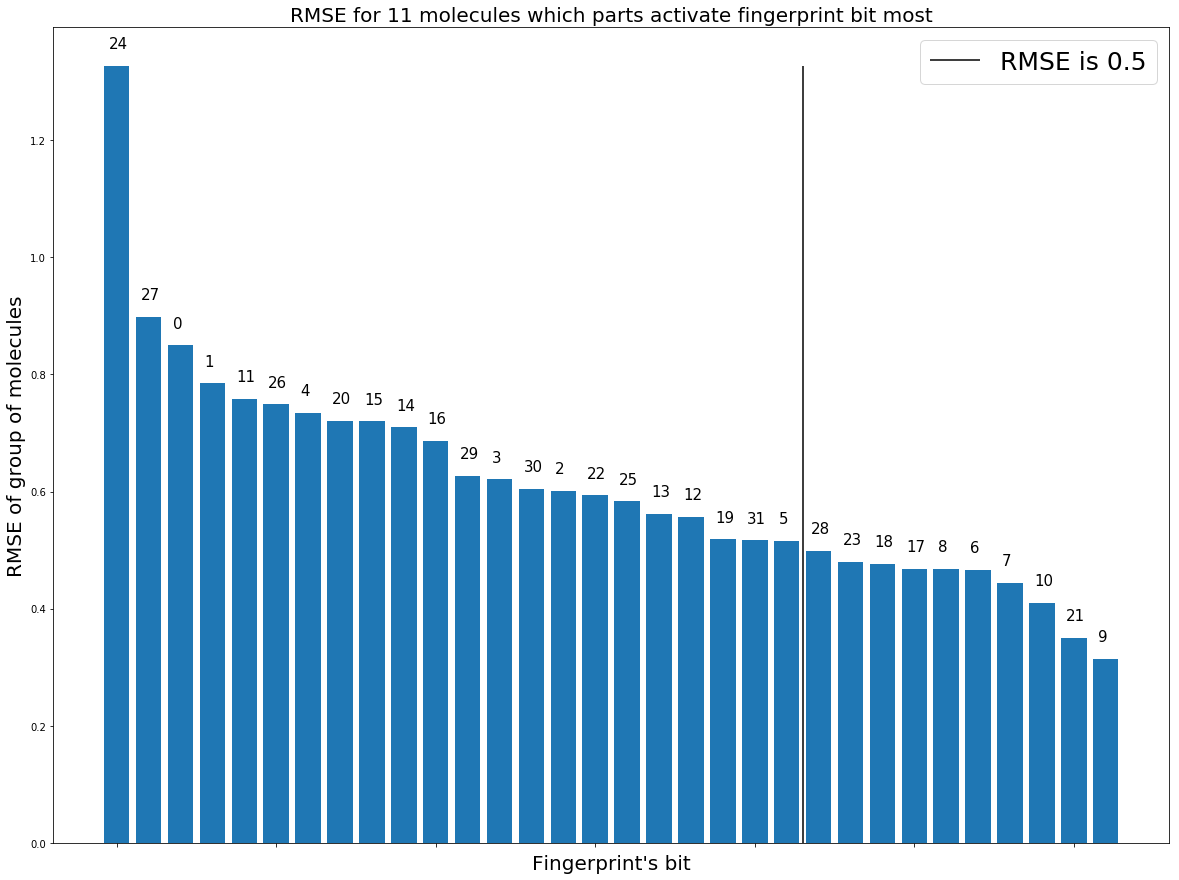

In [173]:
fig, ax = plt.subplots(figsize=(20,15))
# plt.axis('off')
ax.bar(range(32),RMSE_ordered.values())

label = RMSE_ordered.keys()
 
# Text on the top of each barplot
for i in range(len(label)):
    ax.text(x = i-0.25 , y = RMSE_ordered.values()[i]+0.03, s = str(label[i]), size = 15)
_ = ax.set_xticklabels([])

ax.set_ylabel('RMSE of group of molecules', fontsize = 20)
ax.set_xlabel('Fingerprint\'s bit', fontsize = 20)
_ = ax.set_title ('RMSE for 11 molecules which parts activate fingerprint bit most', fontsize = 20)

ax.vlines(x = threshold-0.5, ymin = 0, ymax = max(RMSE_ordered.values()), label = 'RMSE is 0.5')
ax.legend(fontsize=25)

# Create summary images

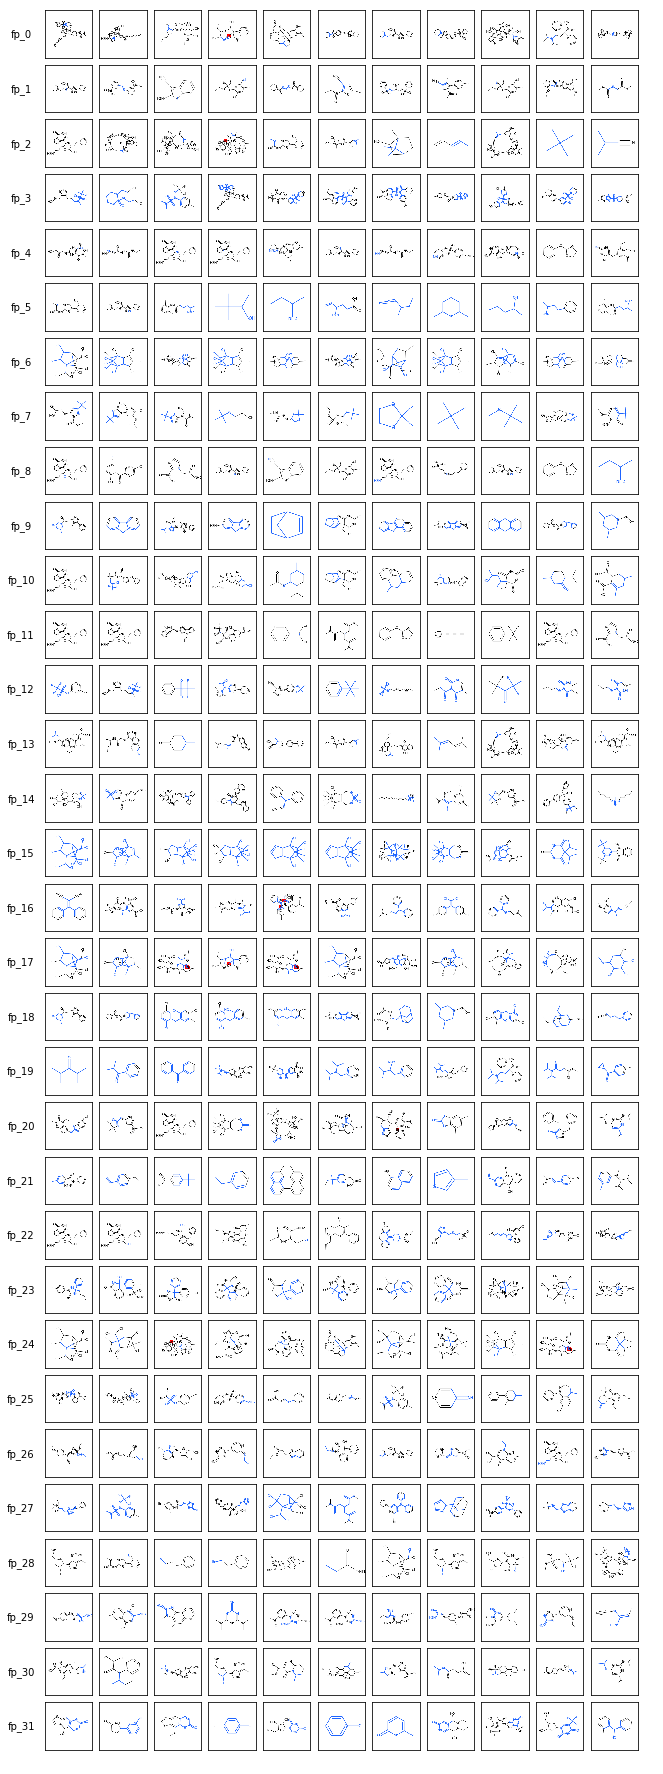

In [178]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

imgs = []

for i in range(params["fp_length"]):
    for j in range(num_figs_per_fp):
        img = mpimg.imread(os.path.join(FIGURE_PATH, 'figures','exp_'+str(NUM_EXP),"fp_"+str(i)+"_highlight_"+str(j)+".png"))
        imgs.append(img)
        



fig = plt.figure(figsize=(num_figs_per_fp, params["fp_length"]))

plt.axis('off')


grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(params["fp_length"], num_figs_per_fp),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
             )

for i, (ax, im) in enumerate(zip(grid, imgs)):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#     print(i, i%num_figs_per_fp)
    if i%num_figs_per_fp==0:
        ax.text(-0.5, 0.5, 'fp_'+str(i//11),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
fig.savefig(os.path.join(FIGURE_PATH, 'figures','exp_'+str(NUM_EXP),'summary_write.png'), dpi=300)
plt.show()

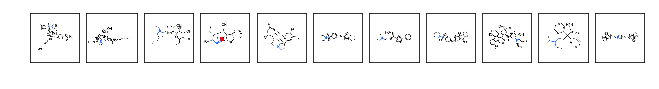

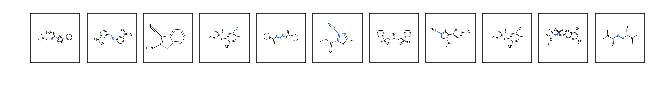

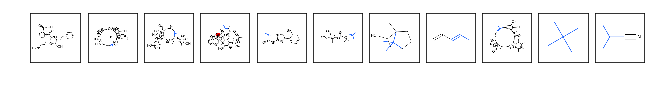

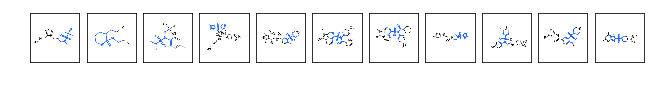

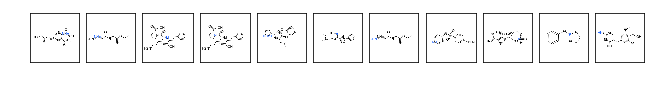

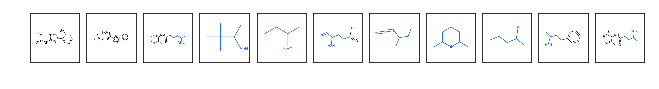

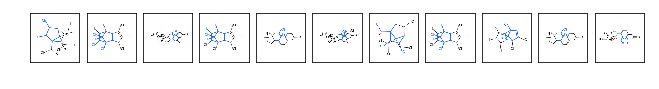

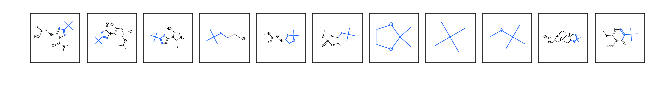

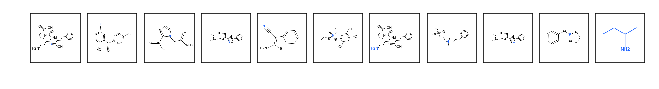

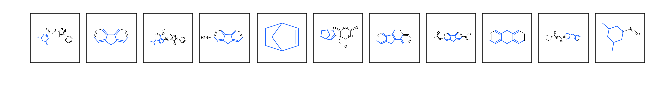

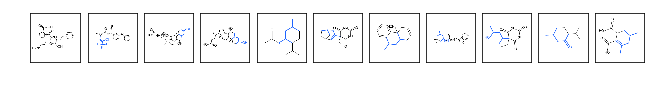

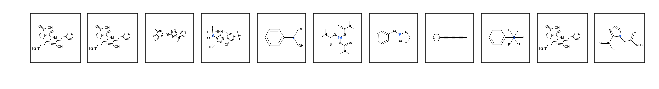

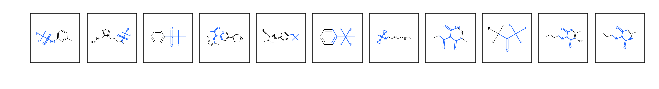

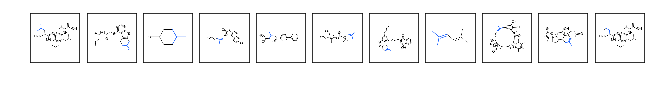

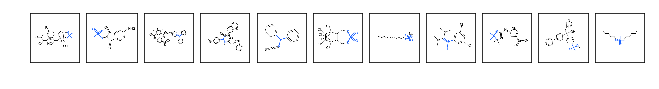

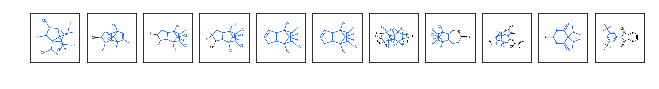

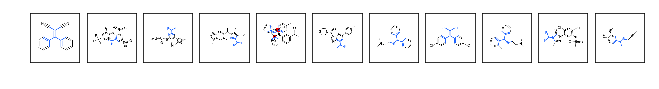

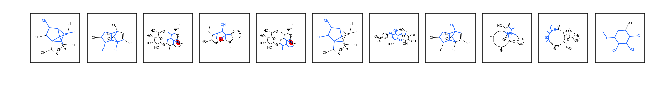

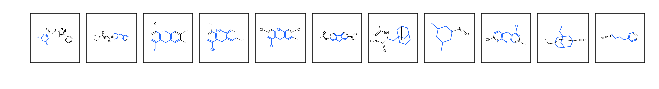

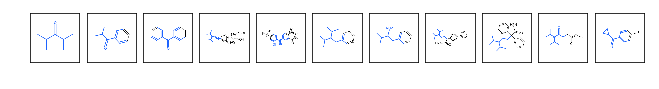

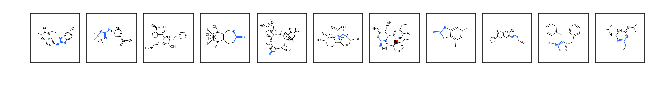

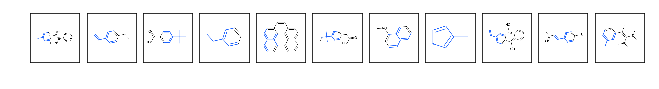

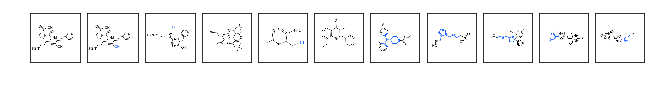

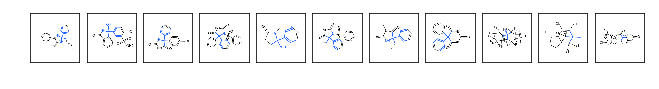

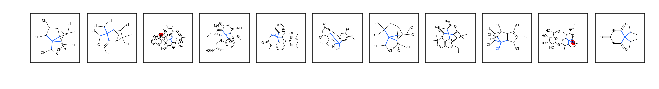

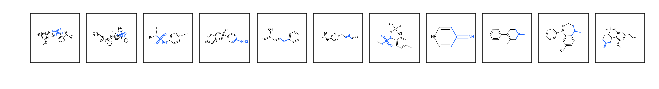

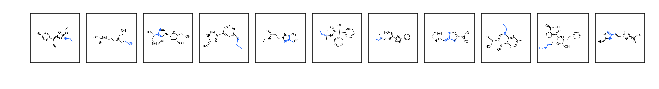

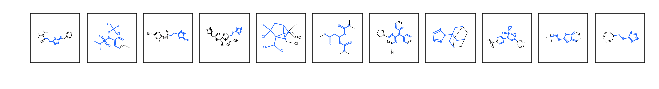

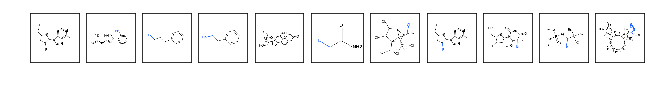

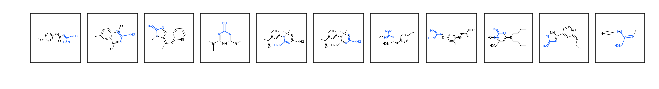

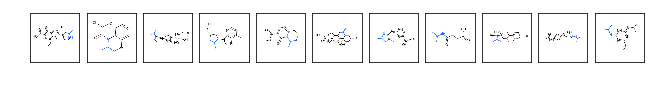

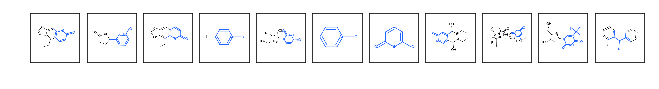

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

imgs = []

for i in range(params["fp_length"]):
    imgs.append([])
    for j in range(num_figs_per_fp):
        img = mpimg.imread(os.path.join(FIGURE_PATH, 'figures','exp_'+str(NUM_EXP),"fp_"+str(i)+"_highlight_"+str(j)+".png"))
        imgs[i].append(img)
        

for i, fp_molecules in enumerate(imgs):

    fig = plt.figure(figsize=(num_figs_per_fp, 1))

    plt.axis('off')


    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, num_figs_per_fp),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                 )

    for ax, im in zip(grid, fp_molecules):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.savefig(os.path.join(FIGURE_PATH, 'figures','exp_'+str(NUM_EXP),'fp_'+str(i)+'_summary.png'), dpi=300)
    plt.show()